In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import requests
import re
import string

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchinfo import summary

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')


## Import text and create dict

In [3]:
# get raw text fro, internet (Time Machine)

text = requests.get('https://www.gutenberg.org/files/35/35-0.txt').text
# chara string to replace with space
strings2replace = [ '\r\n\r\n\â\x90\x9c', 'â\x80\x9c', 'â\x80\x9d', '\r\n','â\x80\x94']
# use reg exp to replace those stings with space
for str2match in strings2replace:
    text = re.compile(r'%s'%str2match).sub(' ',text)

#remove non ascii char and numbers and make lower case
text = re.sub(r'[^\x00-\x7F]+',' ',text)
text = re.sub('\d+', '',text).lower()

#split into words with >1 letter
words = re.split(f'[{string.punctuation}\s]+',text)
words = [item.strip() for item in words if item.strip()]
words = [item for item in words if len(item)>1]

# create vocab 
vocab = sorted(set(words))
nWords = len(words)
nVocab = len(vocab)

# encode/decoder look up tables 
word2idx = {w:i for i,w in enumerate(vocab)}
idx2word = {i:w for i,w in enumerate(vocab)}

print(f'The book contains {nWords} words, {nVocab} of which are unique')
print(f'\n\nFirst 10 vocab words:\n',list(word2idx.keys())[:10]) 

The book contains 30698 words, 4589 of which are unique


First 10 vocab words:
 ['abandon', 'abandoned', 'able', 'abnormally', 'abominable', 'abominations', 'about', 'above', 'abruptly', 'absence']


## Define the para of dataset

In [4]:
# parameters of dataset
context_length = 8 # context length(seq lenght)
stride = 2

#initalize
inputs = []
targets = []

#overlapping seq of context_length
for i in range(0,nWords-context_length, stride):
    # get a few words
    in_seq = words[i:i+context_length]
    targ_seq = words[i+1:i+context_length+1]

    #append to lists
    inputs.append([word2idx[w] for w in in_seq])
    targets.append([word2idx[w] for w in targ_seq])
len(inputs)

15345

In [5]:
print(inputs[123])
print(targets[123])

[1342, 4304, 4119, 342, 4296, 3388, 1474, 131]
[4304, 4119, 342, 4296, 3388, 1474, 131, 209]


In [6]:
print(inputs[124])
print(targets[124])

[4119, 342, 4296, 3388, 1474, 131, 209, 2907]
[342, 4296, 3388, 1474, 131, 209, 2907, 4510]


In [7]:
# we need the above in a different format in torch Dataset/DataLoader format

# We need each list to be a tensor
torch.tensor(inputs[123])

tensor([1342, 4304, 4119,  342, 4296, 3388, 1474,  131])

In [8]:
len(text)

179773

## Create a class for a dataset object

In [9]:
print(len(words))
print('\n\n', words)

30698


 ['start', 'of', 'the', 'project', 'gutenberg', 'ebook', 'the', 'time', 'machine', 'an', 'invention', 'by', 'wells', 'contents', 'introduction', 'ii', 'the', 'machine', 'iii', 'the', 'time', 'traveller', 'returns', 'iv', 'time', 'travelling', 'in', 'the', 'golden', 'age', 'vi', 'the', 'sunset', 'of', 'mankind', 'vii', 'sudden', 'shock', 'viii', 'explanation', 'ix', 'the', 'morlocks', 'when', 'night', 'came', 'xi', 'the', 'palace', 'of', 'green', 'porcelain', 'xii', 'in', 'the', 'darkness', 'xiii', 'the', 'trap', 'of', 'the', 'white', 'sphinx', 'xiv', 'the', 'further', 'vision', 'xv', 'the', 'time', 'traveller', 'return', 'xvi', 'after', 'the', 'story', 'epilogue', 'introduction', 'the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him', 'was', 'expounding', 'recondite', 'matter', 'to', 'us', 'his', 'pale', 'grey', 'eyes', 'shone', 'and', 'twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the', 

In [10]:
class WordDataset(Dataset):
    def __init__(self, text, word2idx, context_length=8, stride=4):

        # init
        self.inputs = []
        self.targets = []
        self.word2idx = word2idx #stored locally in the object

        # overlapping seq of context_length
        for i in range(0,len(text)-context_length,stride):
            #get a few words
            in_seq = text[i:i+context_length]
            targ_seq = text[i+1:i+context_length+1]

            # append to lists
            self.inputs.append(torch.tensor([word2idx[w] for w in in_seq]))
            self.targets.append(torch.tensor([word2idx[w] for w in targ_seq]))

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self,idx):
        return self.inputs[idx], self.targets[idx]


# ceate an instance
context_length = 6
stride = 3
text_dataset = WordDataset(words, word2idx, context_length, stride)

text_dataset[4]

(tensor([4451,  783, 2167, 2005, 4042, 2416]),
 tensor([ 783, 2167, 2005, 4042, 2416, 2006]))

In [11]:
# Create a DataLoader for training
dataloader = DataLoader(text_dataset, 
                        batch_size = 2, # 2 for looking: 32 for training 
                        shuffle = True,
                        drop_last = True
                       )

# have a look at the indices
X,y = next(iter(dataloader))
print('Inputs:')
print(X), print('')

print('Targets:')
print(y), print('\n\n\n')

# and the words
print('Inputs in words (First batch):')
print([idx2word[item.item()] for item in X[0]])
print('')

print('Targets in words (First batch):')
print([idx2word[item.item()] for item in y[0]])

# and the words
print('\n\n\nInputs in words (Second batch):')
print([idx2word[item.item()] for item in X[1]])
print('')

print('Targets in words (Second batch):')
print([idx2word[item.item()] for item in y[1]])

Inputs:
tensor([[1696, 2186,  286,  230, 3720,  230],
        [ 905, 4428, 1248, 1640, 4042, 2822]])

Targets:
tensor([[2186,  286,  230, 3720,  230, 4581],
        [4428, 1248, 1640, 4042, 2822, 4467]])




Inputs in words (First batch):
['get', 'it', 'back', 'as', 'soon', 'as']

Targets in words (First batch):
['it', 'back', 'as', 'soon', 'as', 'you']



Inputs in words (Second batch):
['darkness', 'we', 'emerged', 'from', 'the', 'palace']

Targets in words (Second batch):
['we', 'emerged', 'from', 'the', 'palace', 'while']


In [12]:
type(X)

torch.Tensor

## Build a model to learn the embeddings

In [13]:
# create and explore an embedding layer

embeddingDimension = 100

#create a random embedding
embedding_layer = nn.Embedding(nVocab, embeddingDimension)

#see its size
embedding_layer.weight.shape

torch.Size([4589, 100])

In [14]:
# the embedding_layer is initialised randomly
# Every time a token passes through the model:

#    1.The embedding for that token is selected from the table.

#    2.The model predicts something.

#    3.Loss is computed.

#    4.Gradients update only the rows corresponding to the tokens used.

In [15]:
embedding_layer.weight

Parameter containing:
tensor([[-0.5666, -0.1752,  2.1390,  ..., -0.3810,  0.4050, -0.4931],
        [ 0.0495, -0.3072, -1.5052,  ..., -0.7118, -0.8781, -0.9087],
        [-0.4279, -0.0951, -1.2448,  ..., -0.2349, -0.2271,  0.2066],
        ...,
        [ 0.8127, -0.4292, -2.2208,  ..., -1.1332, -0.7888, -0.1999],
        [-0.2455, -2.0586, -0.6193,  ..., -0.1361,  0.7474, -0.4182],
        [-0.5306,  1.0134,  0.1310,  ..., -1.5662, -0.7979,  0.4001]],
       requires_grad=True)

In [16]:
embedding_layer

Embedding(4589, 100)

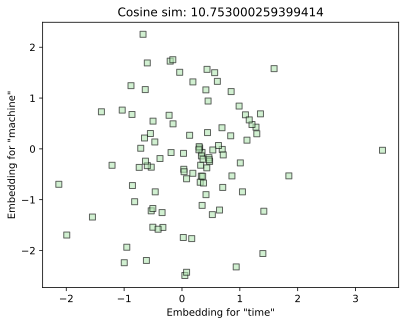

In [17]:
# embeddings for closely related words
word1 = 'time'
word2 = 'machine'

#their embeddings
embed1 = embedding_layer.weight.detach()[word2idx[word1],:]
embed2 = embedding_layer.weight.detach()[word2idx[word2],:]

#cosine sim btw them
cosSim = torch.dot(embed1,embed2)/torch.norm(embed1)*torch.norm(embed2)

plt.plot(embed1,embed2,'ks',markerfacecolor=[.7,.9,.7],alpha=.6)
plt.gca().set(xlabel=f'Embedding for "{word1}"', ylabel = f'Embedding for "{word2}"',
              title = f'Cosine sim: {cosSim}')
plt.show()


In [18]:
# Build the model

class EmbeddingModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size):
        super(EmbeddingModel, self).__init__()

        # embedding layer
        self.embeddings = nn.Embedding(vocab_size,embedding_dim)

        #linear hidden layers
        self.linear1 = nn.Linear(context_size * embedding_dim, 128) #600x128
        self.linear2 = nn.Linear(128, vocab_size) #128*4589

    def forward(self, inputs):
        # the fwd pass process the current token to predict next token
        
        # extract and flatten embeddings, reshapes to [batch_size, context_size * embedding_dim]
        embeds = self.embeddings(inputs).view(inputs.shape[0],-1)

        #fully connected layers
        out = F.relu(self.linear1(embeds)) #connecting to first H.L
        out = self.linear2(out)

        #log softmax for classfcn ( NLLLoss expects logprobs as inputs)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs

# create a model instance
model = EmbeddingModel(vocab_size=nVocab, embedding_dim=embeddingDimension, context_size=context_length)
print(model)



# apply Xavier normlsn on initialise weights, so that Std deviation of weights is tighter
# helps in training
for param in model.parameters():
    if param.dim()>1: #also exlcudes biases
        nn.init.xavier_normal_(param)

EmbeddingModel(
  (embeddings): Embedding(4589, 100)
  (linear1): Linear(in_features=600, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=4589, bias=True)
)


In [19]:
#lets test the model

X,y = next(iter(dataloader))
modelOut = model(X)

print('input to model:')
print(X), print('')

print(f'Output from model (size: {list(modelOut.detach().shape)}):')
print(modelOut)

input to model:
tensor([[1854,  744, 4296, 4041, 1298,  137],
        [4352, 3721,  538, 2402, 4445, 1640]])

Output from model (size: [2, 4589]):
tensor([[-8.4134, -8.3970, -8.4642,  ..., -8.3566, -8.5028, -8.5178],
        [-8.4086, -8.3888, -8.4595,  ..., -8.3596, -8.5065, -8.5153]],
       grad_fn=<LogSoftmaxBackward0>)


In [20]:
y

tensor([[ 744, 4296, 4041, 1298,  137,  817],
        [3721,  538, 2402, 4445, 1640, 2608]])

In [21]:
# the 2X4589 matrix in above output
# each row is the logsoftmax value for every possible word in the vocab to 
# be predicted as the final token in the seq

In [22]:
# log softmax output:
print(modelOut.detach()[0])
print('')

#shouldnt the sum be 1 ??
print(f'Log softmax sum = {modelOut.detach()[0].sum()}')

#ah its *log* softmax :D
print(f'exp(log(softmax) sum = {torch.exp(modelOut.detach()[0]).sum()}')

tensor([-8.4134, -8.3970, -8.4642,  ..., -8.3566, -8.5028, -8.5178])

Log softmax sum = -38697.94140625
exp(log(softmax) sum = 0.9999992847442627


In [23]:
# find word with highest prob
print('Model input:')
print([idx2word[w.item()] for w in X[0]])
print('')

print('Model output:')
print(idx2word[modelOut[0].argmax().item()])

Model input:
['hasty', 'conclusions', 'upon', 'that', 'evening', 'and']

Model output:
mark


In [24]:
# have the model generate text

# grab some data from loader
X,y = next(iter(dataloader))

print('First input:')
print(' '.join([idx2word[w.item()] for w in X[0]]))
print('\nsubsequent inputs:')

# text generation
for _ in range(context_length):
    # get output for this input
    Y = model(X)

    #pick the most liekely next word
    nextWord = Y[0].argmax().item()

    #create new input for next iteration (word)
    X[0] = torch.concatenate((X[0][1:], torch.tensor([nextWord])))

    # print out generated text so far
    print(' '.join([idx2word[w.item()] for w in X[0]]))
    

First input:
entered it was surprised to see

subsequent inputs:
it was surprised to see outlet
was surprised to see outlet mark
surprised to see outlet mark sudden
to see outlet mark sudden brighter
see outlet mark sudden brighter mark
outlet mark sudden brighter mark young


In [25]:
# summary of the model

summary(model,input_data = X, col_names=['input_size', 'output_size','num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
EmbeddingModel                           [2, 6]                    [2, 4589]                 --
├─Embedding: 1-1                         [2, 6]                    [2, 6, 100]               458,900
├─Linear: 1-2                            [2, 600]                  [2, 128]                  76,928
├─Linear: 1-3                            [2, 128]                  [2, 4589]                 591,981
Total params: 1,127,809
Trainable params: 1,127,809
Non-trainable params: 0
Total mult-adds (M): 2.26
Input size (MB): 0.00
Forward/backward pass size (MB): 0.09
Params size (MB): 4.51
Estimated Total Size (MB): 4.60

![alt text for screen readers](./code_arch_mapping.png) 

torch.Size([2, 4589])